In [1]:
import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.svm import LinearSVC

In [4]:
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Подготовка датасета 

In [6]:
to_reg = data.copy()

In [7]:
# Переводим категориальные признаки в цифровые
to_reg = pd.get_dummies(to_reg, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

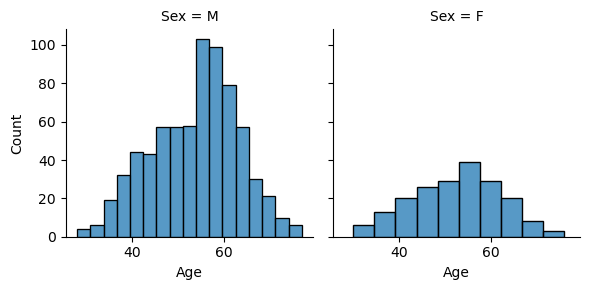

In [8]:
sns.FacetGrid(data, col='Sex').map(sns.histplot, 'Age')
plt.show()

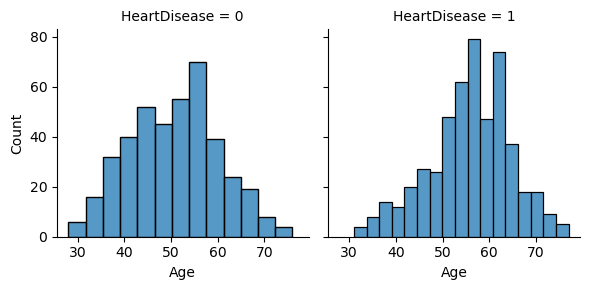

In [9]:
sns.FacetGrid(data, col='HeartDisease').map(sns.histplot, 'Age')
plt.show()

## Разделение выборки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(to_reg.drop(columns=['HeartDisease']), 
                                                    to_reg.HeartDisease,
                                                    test_size=.2,
                                                    random_state=42
                                                   )

### Дерево решений

In [11]:
model_DT = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=1)
)

In [12]:
model_DT.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=1))])

In [13]:
y_pred = model_DT.predict(X_test)

In [14]:
mse_dt, r2_dt = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        77
           1       0.87      0.79      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.81       184



### Рандомный лес

In [16]:
model_RF = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=1)
)

In [17]:
model_RF.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])

In [18]:
y_pred = model_RF.predict(X_test)

In [19]:
mse_rf, r2_rf = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



### Беггинг

In [21]:
model_B = make_pipeline(
    StandardScaler(),
    BaggingClassifier(random_state=1)
)

In [22]:
model_B.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier', BaggingClassifier(random_state=1))])

In [23]:
y_pred = model_B.predict(X_test)

In [24]:
mse_b, r2_b = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85        77
           1       0.94      0.81      0.87       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184



### Стакинг

In [26]:
estimators = [
    ('dt', make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))),
    ('rf', make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))),
    ('svm', make_pipeline(StandardScaler(), LinearSVC(dual='auto', random_state=1)))
]
model_S = make_pipeline(
    StandardScaler(),
    StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
)

In [27]:
model_S.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('dt',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler()),
                                                                 ('decisiontreeclassifier',
                                                                  DecisionTreeClassifier(random_state=1))])),
                                                ('rf',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler()),
                                                                 ('randomforestclassifier',
                                                                  RandomForestClassifier(random_state=1))])),
                                                ('svm',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler()),
                                                                 ('linearsvc',
                                                                  LinearSVC(dual='auto',
                                                                            random_state=1))]))],
                                    final_estimator=LogisticRegression()))])

In [28]:
y_pred = model_S.predict(X_test)

In [29]:
mse_s, r2_s = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        77
           1       0.90      0.86      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



In [31]:
data_ = {
    'DecisionTreeClassifier': {
        'MSE': mse_dt,
        'R2': r2_dt
    },
    'RandomForestClassifier': {
        'MSE': mse_rf,
        'R2': r2_rf
    },
    'BaggingClassifier': {
        'MSE': mse_b,
        'R2': r2_b
    },
    'StackingClassifier': {
        'MSE': mse_s,
        'R2': r2_s
    }
}

In [32]:
pd.DataFrame(data_)

,DecisionTreeClassifier,RandomForestClassifier,BaggingClassifier,StackingClassifier
MSE,0.195652,0.125000,0.141304,0.13587
R2,0.196019,0.486345,0.419347,0.44168
